# Machine Learning: Loan Defaulting customer prediction - (By Siva KP)

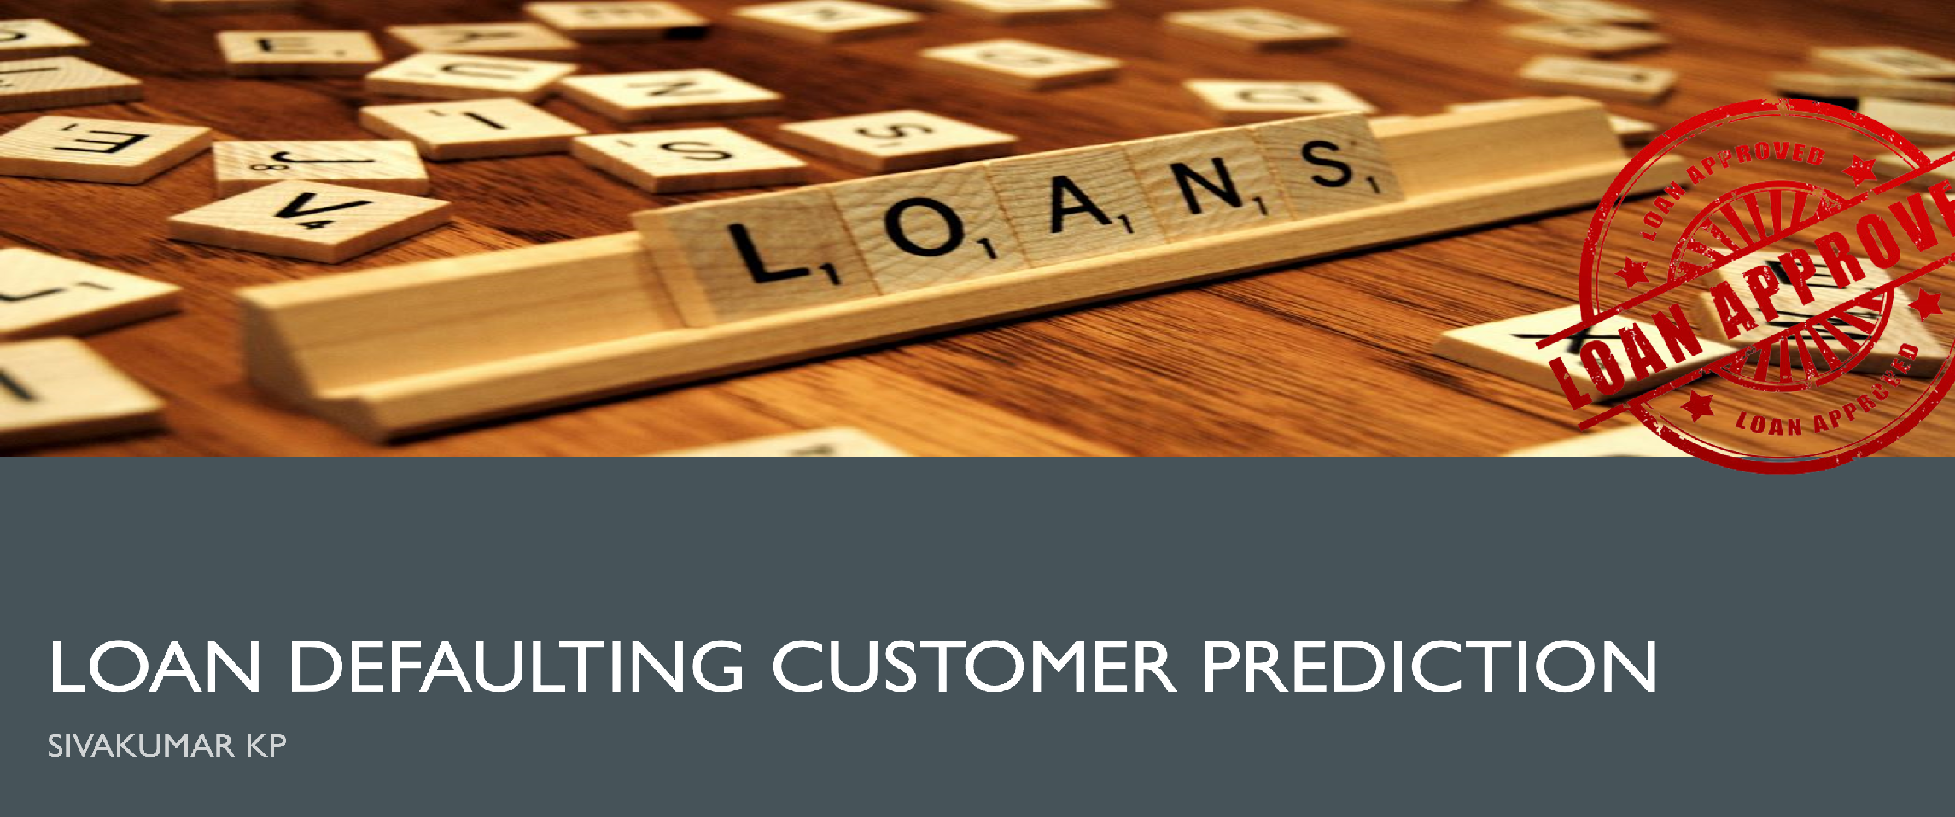

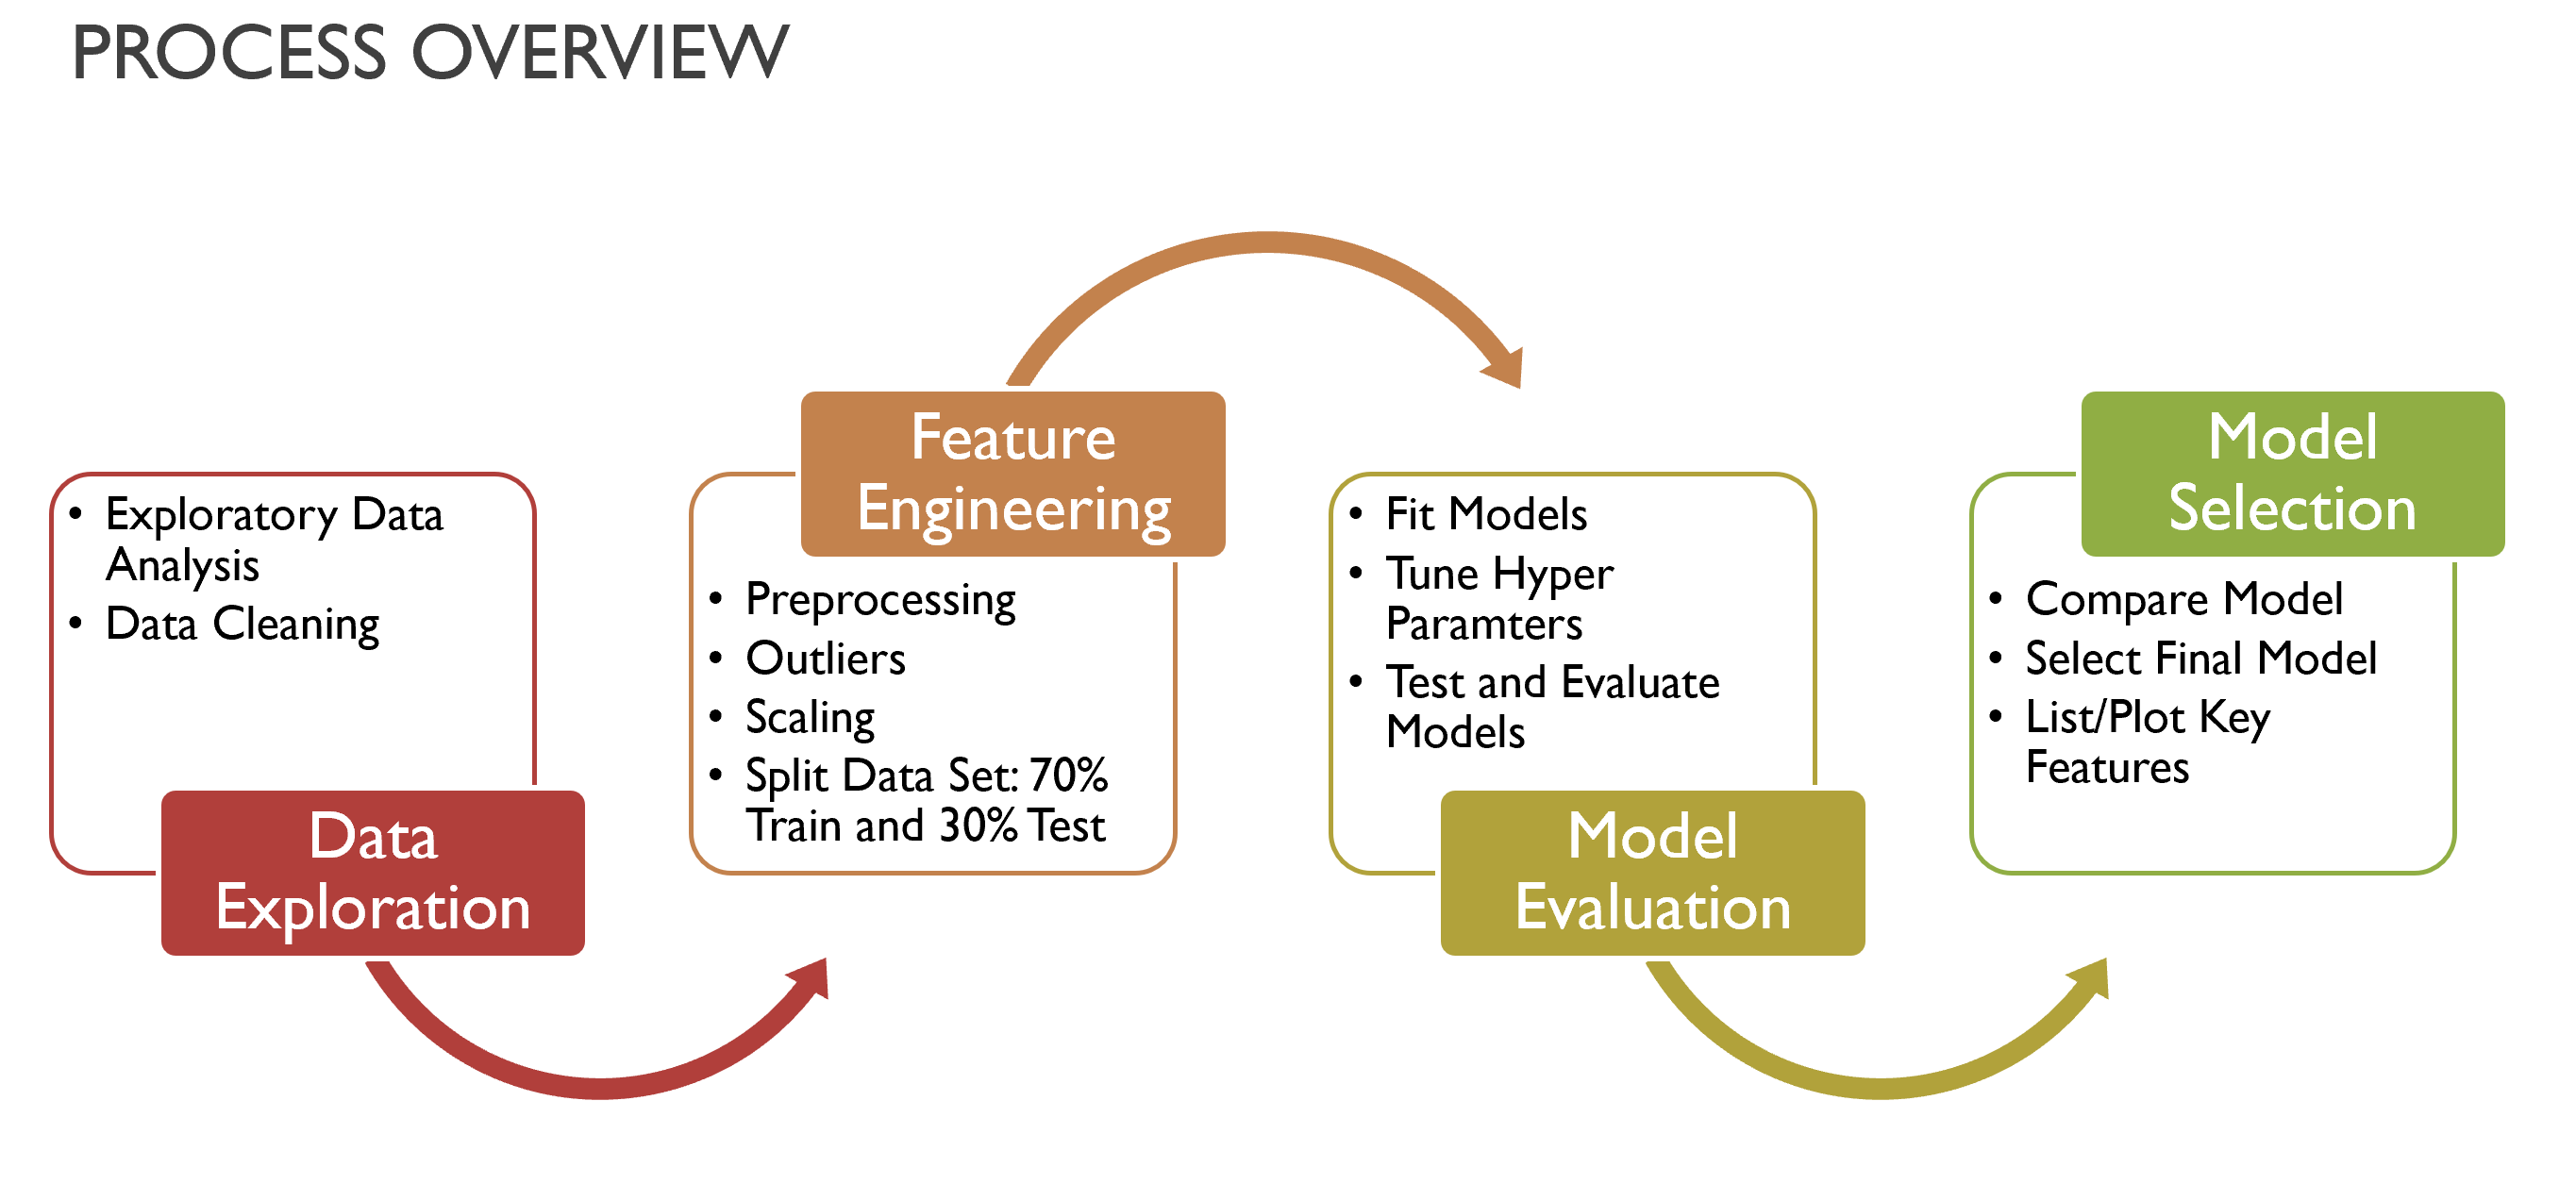

### Import packages for all required transactions

In [1]:
#to save/pickle the model when required
import joblib

#to plot the graphs as required using seaborn, skplot and matplotlib
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

#for connecting to SQL and import data
from sqlalchemy import create_engine
import pymysql

#for pandas and numpy transactions
import pandas as pd
import numpy as np
import pandas_profiling

# scaling and sampling data
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

#train test split
from sklearn.model_selection import train_test_split

#all classification models from scikit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#for gridsearch with Cross validation
from sklearn.model_selection import GridSearchCV


#model metrics to evaluate and choose the best one
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


#miscellaneous like time, warning suppress, print all items etc
from time import time
import time
# to enable print all print items
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to suppress warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

### Data Cleaning and Feature Engineering

In [14]:
df = pd.read_csv("bloan_data.csv") # read locally saved data 

df.shape

(827, 54)

In [15]:
#Set random state to constant number throughout transactions. Say '42' and create a variable to call it across cells

rand_st = 42

In [16]:
#converting dates into datetime format
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['account_date'] = pd.to_datetime(df['account_date'])
df['loan_date'] = pd.to_datetime(df['loan_date'])
df['card_issued_date'] = pd.to_datetime(df['card_issued_date'])


In [17]:
#add new columns as features
df['cards'] = df['card_type'].apply(lambda x: 0 if x == None else 1 ) # with cards or not
#df['age_at_ao'] = df['account_date'].dt.year - df['birth_date'].dt.year # age at Acc opening
df['age_at_lo'] = df['loan_date'].dt.year - df['birth_date'].dt.year # age at Acc opening
#df['acc_age_at_lo'] = df['loan_date'].dt.year - df['account_date'].dt.year # age at Acc opening

df['acc_age_at_lo'] = (df['loan_date'] - df['account_date'])/np.timedelta64(1, 'M') # age at Acc opening

#convert loan status Y label into numeric values
df['loanstat'] = df['loan_status'].apply(lambda x: 1 if x == 'A' else 2 if x == 'B' else 3 if x == 'C' else 4 )

#df.loanstat.value_counts()

#df['loanstat'] = df['loan_status'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else 0 if x == 'C' else 1 )
df['loanstat'] = df['loanstat'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else 0 if x == 3 else 1 )

#drop disponent and keep only main client aka accounts
df = df[df['disp_type']=='OWNER']

# transform crime data of two years into oneby taking average
df['crime'] = (df['crimes95'] + df['crimes96'])/2
df.drop(columns = ['crimes95','crimes96'],inplace=True)

# transform crime data of two years into oneby taking average
df['unemploy'] = (df['unemploy95'] + df['unemploy96'])/2
df.drop(columns = ['unemploy95','unemploy96'],inplace=True)
#df.loanstat.value_counts()

#one hot coding for categorical values where known and having limited combinations like gender
gender = {'m' : 1, 'f': 0}
df['gender'] = df['gender'].map(gender)

#drop some of the features like, date, id, birthdate etc
df.drop(columns = ['account_date','card_issued_date','district_id','card_type','loan_date','birth_date'],inplace=True)
df.drop(columns = ['client_id','disp_id','card_id','client_district_id','account_id','acc_district_id','loan_id'],inplace=True)
df.drop(columns = ['loan_status','disp_type','district_name','loan_amount', 'loan_duration','stmt_freq'],inplace=True)

#df.drop(columns = ['gender'],inplace=True)
df.shape


(682, 37)

### Exploratory Data Analysis using Pandas Profile Report

In [18]:
pandas_profiling.ProfileReport(df)

### Check correlation between each other features and choose what to retain, drop or transform

Heatmap

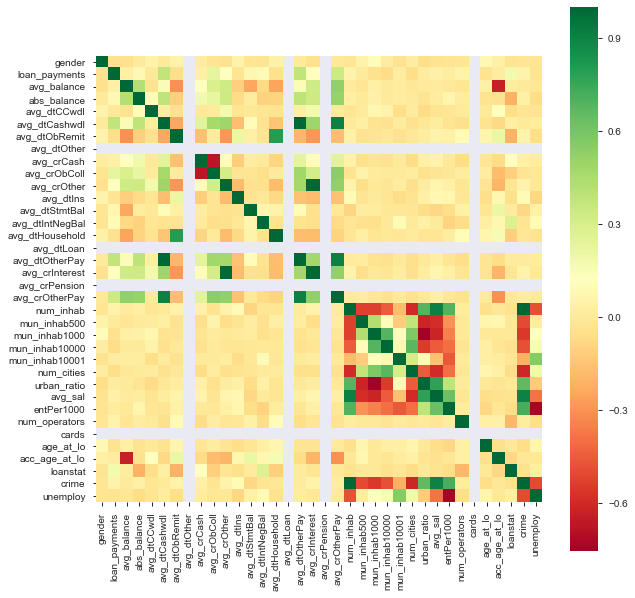

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn', ax=ax)
plt.show();

In [20]:
#drop some of the correlated features
df.drop(columns = ['num_inhab', 'avg_balance', 'mun_inhab500', 'mun_inhab1000', 'mun_inhab10000','mun_inhab10001'],inplace=True)
df.shape


(682, 31)

In [21]:
#save the features file in order to use later
df.to_csv('loan_default_features.csv')

In [22]:
df.columns

Index(['gender', 'loan_payments', 'abs_balance', 'avg_dtCCwdl',
       'avg_dtCashwdl', 'avg_dtObRemit', 'avg_dtOther', 'avg_crCash',
       'avg_crObColl', 'avg_crOther', 'avg_dtIns', 'avg_dtStmtBal',
       'avg_dtIntNegBal', 'avg_dtHousehold', 'avg_dtLoan', 'avg_dtOtherPay',
       'avg_crInterest', 'avg_crPension', 'avg_crOtherPay', 'region',
       'num_cities', 'urban_ratio', 'avg_sal', 'entPer1000', 'num_operators',
       'cards', 'age_at_lo', 'acc_age_at_lo', 'loanstat', 'crime', 'unemploy'],
      dtype='object')

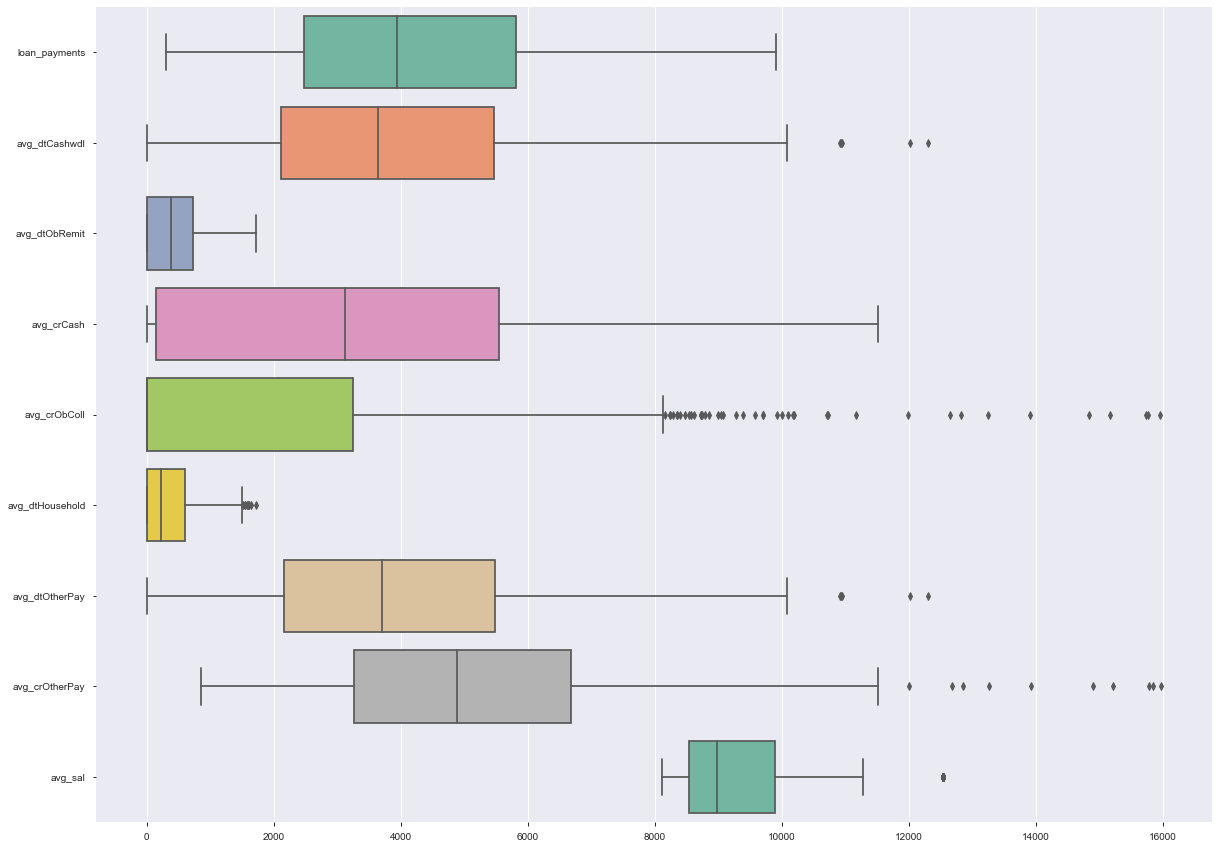

In [23]:
df1 = df[['loan_payments', 'avg_dtCashwdl', 'avg_dtObRemit', 'avg_crCash',
       'avg_crObColl', 'avg_dtHousehold', 'avg_dtOtherPay' ,  'avg_crOtherPay', 'region',
       'avg_sal']]
fig, ax = plt.subplots(figsize = (20,15))
sns.boxplot(data= df1, orient = 'h', palette="Set2", ax = ax )

### Features and Labels (target) separation

In [24]:
X1 = df.drop(columns='loanstat')
y = df.loanstat

X = pd.get_dummies(X1)

### Train test split

use: 33% test size with stratify = y to maintain the same ratio of class ratio between train and test

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = rand_st, stratify = y)

### Scaling the data
- Scale the data using scikit robo scaler (it works better especially when outliers are more among features)

Note: for this excercise, I did not scale as the score was better without scaling the data set

In [58]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Replot the box plot after scalins and plot shows data is scaled at its best

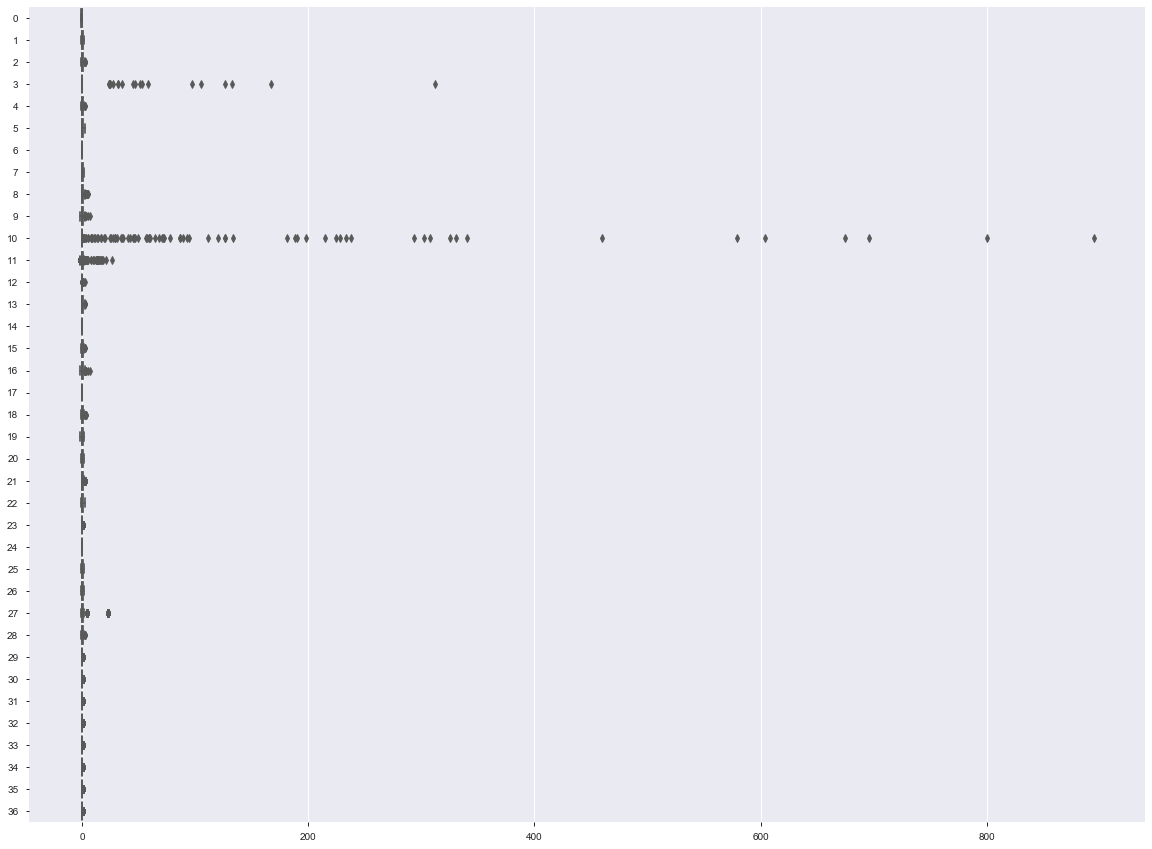

In [59]:
fig, ax = plt.subplots(figsize = (20,15))
sns.boxplot(data= X_train_scaled, orient = 'h', palette="Set2", ax = ax )

## Functions
- Print Best Parameters and its relevant scores for each of hyper parameters.

In [60]:
def print_results(modelname, results):
    print(F"{modelname}_Best PARAMS: {results.best_params_}")

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f"Mean:{round(mean, 3):6} STD:(+/-{round(std * 2, 3):5}) for {params}")

- Gridsearch with set of hyper paramters and pickle the model with best scores

In [29]:
def grid_searchcv(name, model, param, Xtrain, ytrain):
    cv = GridSearchCV(model, param, cv=5)
    cv.fit(Xtrain, ytrain)
    print_results(name, cv)
    joblib.dump(cv.best_estimator_, f"{name}_model.pkl")
    print(f"\n{name}_model.pkl is saved.")

In [30]:
def evaluate_model(name, model, features, labels):
    
    start = time.time() #start time of model prediction
    
    y_pred = model.predict(features)  # Y prediction for X test features
    
    end = time.time() #start time of model prediction
    
    #difference kinds of model metrics to evaluate and choose the best model
    accuracy = round(accuracy_score(labels, y_pred), 3)
    precision = round(precision_score(labels, y_pred), 3)
    recall = round(recall_score(labels, y_pred), 3)
    f1 = round(f1_score(labels, y_pred), 3)
    latency = round((end - start)*1000, 1)
    
    print(f"{name:3}: Accuracy:{accuracy:5}, Precision:{precision:5}, Recall:{recall:5}, F1:{f1:5},Latency:{latency:5}ms")


In [31]:
def evaluate_and_plot_model(name, model, features, labels):
        
    y_pred = model.predict(features)  # Y prediction for X test features    


    #print classification report
    print(f"Classification Matrics for: {name}")
    print(classification_report(labels,y_pred))
    
    time.sleep(1)
    #plot confusion metrics
    print(f"Confusion Matrix for: {name}")
    skplt.metrics.plot_confusion_matrix(labels, y_pred);
    plt.show() # show the plot
    time.sleep(1)

    #plot roc curve
    print(f"ROC curve for: {name}")
    y_probs = model.predict_proba(features)[:, 1]
    roc_value1 = roc_auc_score(labels, y_probs) # Calculate roc auc
    fpr1, tpr1, thresholds1 = roc_curve(labels, y_probs) # calculate roc curve
    
    plt.plot(fpr1, tpr1, label=name, marker='.', color = 'r') # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show() # show the plot
    time.sleep(1)


### Class imbalance handling: through SMOTE oversampling
2. 88:12 ratio for 0:1, hence overampling is preferred and SMOTE is safest option which generates data with out introducing any outliers or anamolies [SMOTE over sampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)

In [61]:
#train set
X_train.shape
y_train.shape
y_train.value_counts(normalize = True)

(511, 37)

(511,)

0    0.888454
1    0.111546
Name: loanstat, dtype: float64

Training set with SMOTE Oversampling

In [62]:
smote = SMOTE(random_state=rand_st)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

X_train_smote.shape
y_train_smote.shape
pd.Series(y_train_smote).value_counts(normalize = True) #covert numpy array to panda series and value counts

(908, 37)

(908,)

1    0.5
0    0.5
dtype: float64

## Logistic Regression Classification 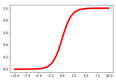

In [63]:
lr = LogisticRegression(random_state = rand_st)
lrparams = {'class_weight' : [None],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_searchcv('LR',lr,lrparams, X_train_smote, y_train_smote)

LR_Best PARAMS: {'C': 10, 'class_weight': None}
Mean:  0.77 STD:(+/-0.068) for {'C': 0.001, 'class_weight': None}
Mean: 0.772 STD:(+/-0.062) for {'C': 0.01, 'class_weight': None}
Mean:  0.77 STD:(+/-0.034) for {'C': 0.1, 'class_weight': None}
Mean: 0.768 STD:(+/-0.058) for {'C': 1, 'class_weight': None}
Mean: 0.778 STD:(+/-0.061) for {'C': 10, 'class_weight': None}
Mean: 0.773 STD:(+/-0.067) for {'C': 100, 'class_weight': None}
Mean: 0.773 STD:(+/- 0.07) for {'C': 1000, 'class_weight': None}

LR_model.pkl is saved.



## Decision Tree Classification 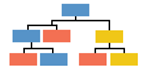

In [64]:
dt = DecisionTreeClassifier(random_state = rand_st)
dtparams = {'max_depth': [2, 4, 8, 16, 32,None],'class_weight' : [None]}
grid_searchcv('DT',dt,dtparams, X_train_smote, y_train_smote)

DT_Best PARAMS: {'class_weight': None, 'max_depth': 16}
Mean: 0.783 STD:(+/-0.068) for {'class_weight': None, 'max_depth': 2}
Mean: 0.869 STD:(+/-0.066) for {'class_weight': None, 'max_depth': 4}
Mean: 0.911 STD:(+/-0.066) for {'class_weight': None, 'max_depth': 8}
Mean: 0.915 STD:(+/-0.076) for {'class_weight': None, 'max_depth': 16}
Mean: 0.915 STD:(+/-0.076) for {'class_weight': None, 'max_depth': 32}
Mean: 0.915 STD:(+/-0.076) for {'class_weight': None, 'max_depth': None}

DT_model.pkl is saved.


## KNN Classifier 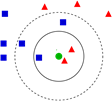

In [65]:
knn = KNeighborsClassifier()
knnparams = {'n_neighbors': [3],'leaf_size':[10,20,30]}
grid_searchcv('KNN',knn,knnparams, X_train_smote, y_train_smote)

KNN_Best PARAMS: {'leaf_size': 10, 'n_neighbors': 3}
Mean: 0.868 STD:(+/-0.032) for {'leaf_size': 10, 'n_neighbors': 3}
Mean: 0.868 STD:(+/-0.032) for {'leaf_size': 20, 'n_neighbors': 3}
Mean: 0.868 STD:(+/-0.032) for {'leaf_size': 30, 'n_neighbors': 3}

KNN_model.pkl is saved.


## RandomForest Classification 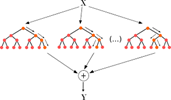

In [66]:
rf = RandomForestClassifier(random_state = rand_st)
rfparams = {'n_estimators': [5, 50, 100], 'max_depth': [2, 4, 8, 16, 32, None],'class_weight' : [None]}
grid_searchcv('RF',rf,rfparams, X_train_smote, y_train_smote)

RF_Best PARAMS: {'class_weight': None, 'max_depth': 32, 'n_estimators': 100}
Mean: 0.813 STD:(+/-0.042) for {'class_weight': None, 'max_depth': 2, 'n_estimators': 5}
Mean: 0.902 STD:(+/-0.047) for {'class_weight': None, 'max_depth': 2, 'n_estimators': 50}
Mean: 0.896 STD:(+/-0.046) for {'class_weight': None, 'max_depth': 2, 'n_estimators': 100}
Mean: 0.883 STD:(+/-0.037) for {'class_weight': None, 'max_depth': 4, 'n_estimators': 5}
Mean: 0.933 STD:(+/-0.055) for {'class_weight': None, 'max_depth': 4, 'n_estimators': 50}
Mean: 0.934 STD:(+/-0.057) for {'class_weight': None, 'max_depth': 4, 'n_estimators': 100}
Mean: 0.927 STD:(+/-0.066) for {'class_weight': None, 'max_depth': 8, 'n_estimators': 5}
Mean: 0.966 STD:(+/-0.057) for {'class_weight': None, 'max_depth': 8, 'n_estimators': 50}
Mean: 0.968 STD:(+/-0.049) for {'class_weight': None, 'max_depth': 8, 'n_estimators': 100}
Mean: 0.952 STD:(+/-0.047) for {'class_weight': None, 'max_depth': 16, 'n_estimators': 5}
Mean:  0.97 STD:(+/-0.0

## GradientBoosting Classification 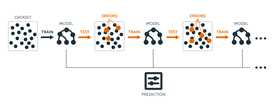

In [67]:
gb = GradientBoostingClassifier(random_state = rand_st)
gbparams = {'n_estimators': [5, 50, 250],
            'max_depth': [1, 3, 5, 7, 9,11,13,15],
            'learning_rate': [0.01, 0.1, 1, 10, 100]}

grid_searchcv('GB',gb,gbparams, X_train_smote, y_train_smote)

GB_Best PARAMS: {'learning_rate': 1, 'max_depth': 7, 'n_estimators': 50}
Mean: 0.744 STD:(+/-0.044) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
Mean: 0.744 STD:(+/-0.044) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
Mean:  0.86 STD:(+/-0.066) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
Mean: 0.865 STD:(+/-0.068) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
Mean: 0.869 STD:(+/-0.069) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Mean:  0.93 STD:(+/-0.057) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
Mean: 0.898 STD:(+/-0.071) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
Mean: 0.907 STD:(+/-0.061) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Mean: 0.946 STD:(+/-0.063) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
Mean: 0.915 STD:(+/-0.054) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}
Mean: 0.922 STD:(+

### Fetch model metrics for comparision

In [68]:
#load saved model from pickle

models = {}

for mdl in ['LR','DT','KNN','RF', 'GB']:
    models[mdl] = joblib.load(f'{mdl}_model.pkl')

Cllisfication Matrics for: LR
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       152
           1       0.30      0.74      0.43        19

    accuracy                           0.78       171
   macro avg       0.63      0.76      0.65       171
weighted avg       0.89      0.78      0.82       171

Confusion Matrix for: LR


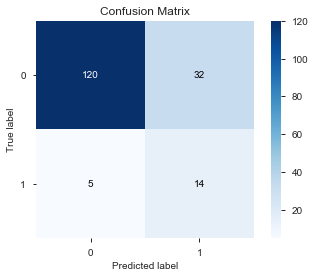

ROC curve for: LR


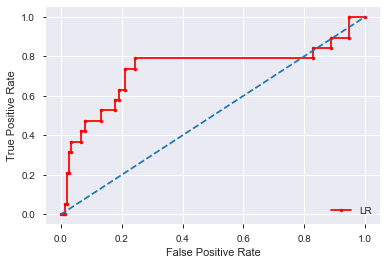

Cllisfication Matrics for: DT
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       152
           1       0.45      0.47      0.46        19

    accuracy                           0.88       171
   macro avg       0.69      0.70      0.70       171
weighted avg       0.88      0.88      0.88       171

Confusion Matrix for: DT


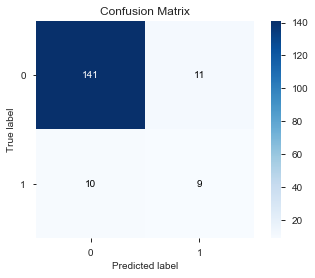

ROC curve for: DT


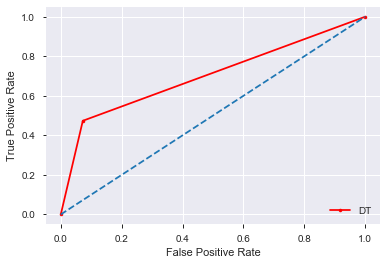

Cllisfication Matrics for: KNN
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       152
           1       0.19      0.47      0.27        19

    accuracy                           0.72       171
   macro avg       0.56      0.61      0.55       171
weighted avg       0.84      0.72      0.76       171

Confusion Matrix for: KNN


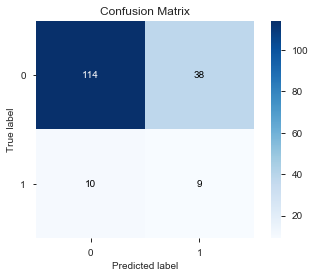

ROC curve for: KNN


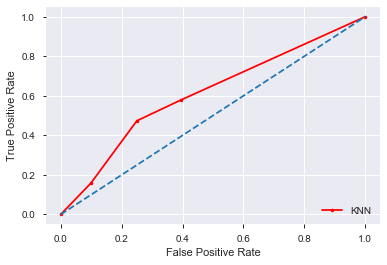

Cllisfication Matrics for: RF
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       152
           1       0.91      0.53      0.67        19

    accuracy                           0.94       171
   macro avg       0.93      0.76      0.82       171
weighted avg       0.94      0.94      0.93       171

Confusion Matrix for: RF


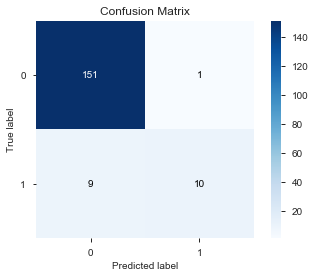

ROC curve for: RF


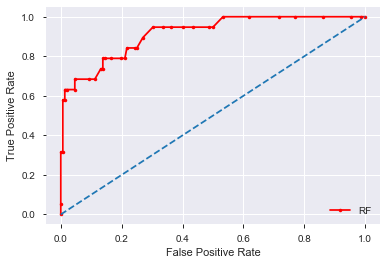

Cllisfication Matrics for: GB
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       152
           1       0.72      0.68      0.70        19

    accuracy                           0.94       171
   macro avg       0.84      0.83      0.83       171
weighted avg       0.93      0.94      0.93       171

Confusion Matrix for: GB


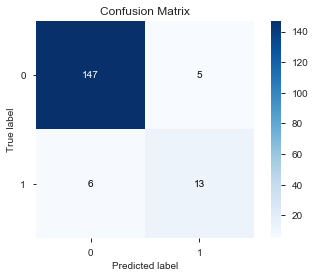

ROC curve for: GB


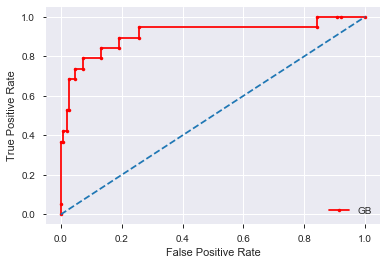

In [69]:
for name, mdl in models.items():
    evaluate_and_plot_model(name, mdl, X_test, y_test)

In [70]:
for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

LR : Accuracy:0.784, Precision:0.304, Recall:0.737, F1:0.431,Latency:  2.0ms
DT : Accuracy:0.877, Precision: 0.45, Recall:0.474, F1:0.462,Latency:  1.0ms
KNN: Accuracy:0.719, Precision:0.191, Recall:0.474, F1:0.273,Latency:  8.0ms
RF : Accuracy:0.942, Precision:0.909, Recall:0.526, F1:0.667,Latency:  7.0ms
GB : Accuracy:0.936, Precision:0.722, Recall:0.684, F1:0.703,Latency:  1.0ms


### Plot ROC curve for all the model for comparision

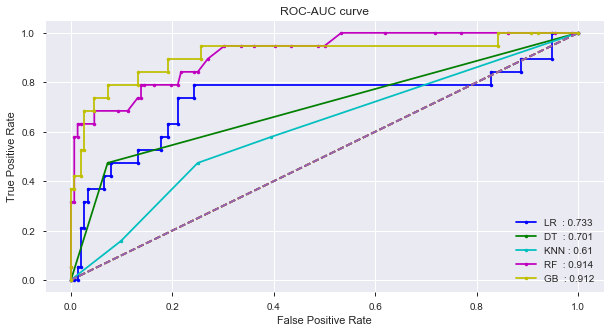

In [71]:
plt.figure(figsize=(10, 5))

clr = ['b','g','c','m','y','k','r','w']
i = 0

for name, mdl in models.items():
    y_probs = mdl.predict(X_test)
    y_probs = mdl.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_probs) # Calculate roc auc
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_probs) # calculate roc curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr1, tpr1, 
             label= f"{name:4}: {round(roc_auc,3)}",
             marker='.', 
             color = clr[i]); # plot the roc curve for the model
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('ROC-AUC curve')
    _ = plt.legend(loc="lower right")

    i += 1

plt.show();

# Recommended Model is - GRADIENTBOOSTING

### Feature Importance

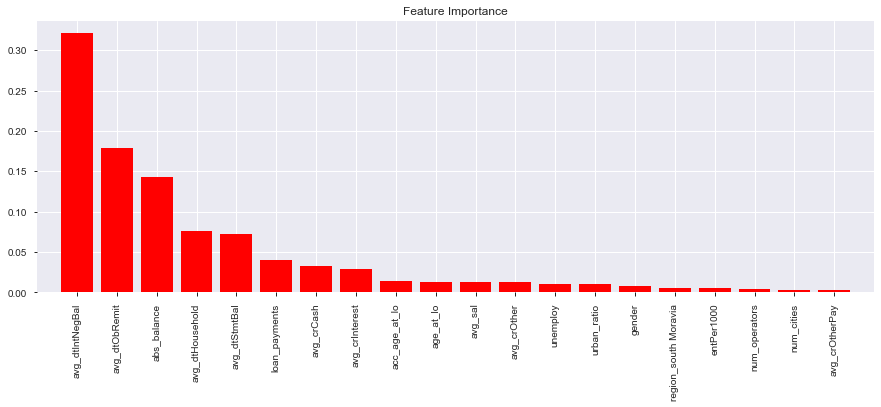

In [73]:
skplt.estimators.plot_feature_importances(joblib.load('GB_model.pkl'), feature_names=X.columns,x_tick_rotation = 90,figsize = (15,5));